In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re
import json

import seaborn as sns
import pgeocode as pg
dist = pg.GeoDistance('us')

%matplotlib inline

from multiprocessing import Pool
from functools import partial

pd.set_option('display.max_columns', None)

def parallelize(data, func, num_of_processes=12):
    data_split = np.array_split(data, num_of_processes)
    pool = Pool(num_of_processes)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data


def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)


def parallelize_on_rows(data, func, num_of_processes=12):
    return parallelize(data, partial(run_on_subset, func), num_of_processes)

In [2]:
REGION='RadnetMA'
# RadnetNE, RadnetFL
ACT_START_DATE='2019-07-22'
DURATION=7

cst_file_path='/shared/rodrigo/preact/customer_metadata_'+REGION+'.csv.edit'

visit_file_path='/shared/data/visit_history_data/customer_visit_history_'+REGION+'.csv'
act_file_path='/shared/data/ACT_history_data/customer_ACT_history.csv'

cst_file_path, visit_file_path, act_file_path

('/shared/rodrigo/preact/customer_metadata_RadnetMA.csv.edit',
 '/shared/data/visit_history_data/customer_visit_history_RadnetMA.csv',
 '/shared/data/ACT_history_data/customer_ACT_history.csv')

In [3]:
cst = pd.read_csv(cst_file_path, low_memory=False)

(697785, 37)


,id,date_of_birth,address_state,address_zipcode,is_duplicate,is_deceased,is_deactivated,cell_phone,first_name,home_phone,last_name,middle_name,mrn,work_phone,escalation_level,is_lead,preferred_language,db_group_id,death_flag,deleted_flag,race_type_code,ethnic_origin_code,last_medication_sync,primary_address_city,primary_address_state,primary_language_code,no_alternate_phone_flag,primary_address_country,primary_address_zipcode,contact_method_type_code,last_breast_density_code,delivery_method_type_code,no_longer_menstruating_flag,taxbracket_max,taxbracket_pos,zipcodeincome_percapita,adjusted_zip
0,1006841,1959-02-26,DE,19709,False,NaN,False,2.406406e+09,KAREN,2.406406e+09,KOSH,R,2565762AM,NaN,0,False,en-us,5,N,N,Black or African American,Not Hispanic or Latino,NaN,Middletown,DE,EN,N,US,19709,M,S,Mail,N,157500.0,Bracket (mintax 1->maxtax 7): 4/7,88255.0,NaN
1,1006852,1953-11-27,DE,19709,True,NaN,False,NaN,MELINDA,3.024496e+09,SARINO,REYES,2529069AM,NaN,0,False,en-us,5,N,N,Declined to Specify,Hispanic or Latino,NaN,MIDDLETOWN,DE,EN,N,NaN,19709,HP,S,NaN,N,157500.0,Bracket (mintax 1->maxtax 7): 4/7,88255.0,NaN
2,1006853,1959-08-15,AZ,85087,False,NaN,False,6.107424e+09,MARY,6.107424e+09,BECKER PASHA,F,2534784AM,3.024987e+09,0,False,en-us,5,N,N,No race assigned,No ethnicity assigned,NaN,New River,AZ,NaN,N,US,85087,NaN,NaN,NaN,N,157500.0,Bracket (mintax 1->maxtax 7): 4/7,84283.0,NaN
3,1006856,1977-03-24,DE,19702,False,NaN,False,4.103222e+09,ANN,4.103222e+09,FLUTKA,MARIE,2551964AM,NaN,0,False,en-us,5,N,N,White,Not Hispanic or Latino,NaN,Newark,DE,EN,Y,US,19702,CP,H,E,Y,82500.0,Bracket (mintax 1->maxtax 7): 3/7,66672.0,NaN
4,1006861,1937-07-22,DE,19803,False,NaN,False,3.029838e+09,MARGARET,3.027644e+09,CONSIGLIO,VOGEL,2586322AM,NaN,0,False,en-us,5,N,N,White,No ethnicity assigned,NaN,WILMINGTON,DE,EN,N,NaN,19803,NaN,F,NaN,N,157500.0,Bracket (mintax 1->maxtax 7): 4/7,115125.0,NaN


In [5]:
act = pd.read_csv(act_file_path, low_memory=False)

(5249824, 8)


,customer_id,created_on,attempt_status_time,stage,communication_mode,attempt_status,customer_response_time,customer_response
0,4907378,2019-10-07 14:42:47.392787+00:00,2019-10-07 14:46:28.307360+00:00,20.0,sms,delivered,NaN,NaN
1,980305,2019-07-22 13:07:43.750454+00:00,2019-09-19 18:37:17.035842+00:00,30.0,voice_call,voice_mail,2019-09-19 18:37:17.035842+00:00,NaN
2,7972137,2020-10-21 12:13:07.895415+00:00,2020-10-21 12:14:27.507719+00:00,50.0,sms,delivered,NaN,NaN
3,1496021,2019-10-09 15:54:49.004968+00:00,2019-10-09 15:57:02.299909+00:00,90.0,sms,delivered,NaN,NaN
4,1010875,2019-09-04 12:04:59.418744+00:00,2019-09-04 12:05:02.299066+00:00,20.0,sms,undelivered,NaN,NaN


In [6]:
visits = pd.read_csv(visit_file_path, low_memory=False)

(5290257, 13)


,customer_id,id,date_of_visit,modality,internal_procedure_code,clinic_group,site_code,clinic_zipcode,visit_ts,birad_score,primary_ins,secondary_ins,requested_by_npi
0,6051340,12611264,2017-11-24,US,US500,RadnetCRA,GRB,20770,2017-11-24 20:00:00+00:00,NaN,SELFPAY NO OTC,NaN,NaN
1,5507787,9747040,2016-06-16,CR,73502,RadnetCRA,CL,20735,2016-06-16 19:26:00+00:00,NaN,SELFPAY NO OTC,NaN,NaN
2,6051340,12550270,2017-11-24,MG_scr,G0202T,RadnetCRA,GRB,20770,2017-11-24 14:45:00+00:00,2.0,SELFPAY NO OTC,NaN,1407897325
3,5507787,9747039,2016-06-16,CR,XR707,RadnetCRA,CL,20735,2016-06-16 19:20:00+00:00,NaN,SELFPAY NO OTC,NaN,NaN
4,4516754,12553906,2017-11-13,CR,72040,RadnetADV,KO,21043,2017-11-13 20:50:00+00:00,NaN,SELFPAY NO OTC,NaN,NaN


In [7]:
clinic_group_map = visits.groupby('clinic_group')[['clinic_zipcode']].agg(pd.Series.mode).to_dict()
clinic_group_map = clinic_group_map['clinic_zipcode']

In [8]:
# impute clinic zip code
def fix_clinic_zip(row):
    z = row['clinic_zipcode']
    if re.match('\d{5}$', z) is None:
        row['clinic_zipcode'] = clinic_group_map[row['clinic_group']]
    
    return row['clinic_zipcode']

visits['clinic_zipcode'] = parallelize_on_rows(visits, fix_clinic_zip, num_of_processes=12)

In [9]:
cst = cst[~cst.address_zipcode.isnull()]

In [10]:
# fix customers zip codes
def fix_customer_zip(row):
    z = row['address_zipcode']
    if re.match('\d{5}$', z) is None:
        row['address_zipcode'] = None
    return row['address_zipcode']

cst['address_zipcode'] = parallelize_on_rows(cst, fix_customer_zip, num_of_processes=12)
cst = cst[~cst.address_zipcode.isnull()]
cst_data = cst[['id', 'date_of_birth', 'address_zipcode', 'zipcodeincome_percapita']].set_index('id').to_dict('index')

In [11]:
dist_dict = {}
with open('inter_zip_dist_full.json') as fh:
    dist_dict = json.load(fh)
    
def calc_dist(row):
    z1 = row['address_zipcode'][:5]
    z2 = row['clinic_zipcode'][:5]
    if f'{z1}-{z2}' in dist_dict or f'{z2}-{z1}' in dist_dict:
        dst = dist_dict.get(f'{z1}-{z2}', 0.0) + dist_dict.get(f'{z2}-{z1}', 0.0)
    else:
        if z1 == z2:
            dst = 0
        else:
            dst = dist.query_postal_code(z1, z2)
            if dst > 100:
                dst = 100
        dist_dict[f'{z1}-{z2}'] = dst
    
    return dst

In [12]:
# valid only act
act = act[act.attempt_status.isin(['delivered', 'voice_mail', 'response_received', 'voice_mail_only'])]

In [14]:
# save act date only
act_date=act[(act.stage<=20)][['customer_id','created_on']]

In [16]:
# remove duplicate visits
visits=visits.drop_duplicates(subset='id', keep="first")

In [17]:
# consider only MG screening visits
visits_scr = visits[visits.modality == 'MG_scr']

In [18]:
# for all these customers, also fill in the customer data
cst.columns

Index(['id', 'date_of_birth', 'address_state', 'address_zipcode',
       'is_duplicate', 'is_deceased', 'is_deactivated', 'cell_phone',
       'first_name', 'home_phone', 'last_name', 'middle_name', 'mrn',
       'work_phone', 'escalation_level', 'is_lead', 'preferred_language',
       'db_group_id', 'death_flag', 'deleted_flag', 'race_type_code',
       'ethnic_origin_code', 'last_medication_sync', 'primary_address_city',
       'primary_address_state', 'primary_language_code',
       'no_alternate_phone_flag', 'primary_address_country',
       'primary_address_zipcode', 'contact_method_type_code',
       'last_breast_density_code', 'delivery_method_type_code',
       'no_longer_menstruating_flag', 'taxbracket_max', 'taxbracket_pos',
       'zipcodeincome_percapita', 'adjusted_zip'],
      dtype='object')

In [21]:
cst = cst.rename(columns={"id": "customer_id"})

In [268]:
# remove scr visits for which customer data is not available
visits_scr = visits_scr.loc[visits_scr.customer_id.isin(cst.customer_id)]

# add customer data to visit data
visits_scr_cst = visits_scr.merge(cst, on='customer_id', how='inner')
visits_scr_cst['visit_datetime'] = pd.to_datetime(visits_scr_cst.loc[:, 'date_of_visit'])

# with ACT
visits_scr_cst_act = visits_scr_cst.loc[visits_scr_cst.customer_id.isin(act_date.customer_id)]

# without ACT
visits_scr_cst_wo_act = visits_scr_cst.loc[~visits_scr_cst.customer_id.isin(act_date.customer_id)]

In [269]:
visits_scr_cst_act.shape, visits_scr_cst_wo_act.shape, visits_scr_cst.shape

((774371, 50), (1339007, 50), (2113378, 50))

In [271]:
# use *55* or 65 for binary def of younger
def get_age(row):
    visit = row['date_of_visit']
    dob = row['date_of_birth']
    born = datetime.strptime(dob, '%Y-%m-%d')
    vd = datetime.strptime(visit, '%Y-%m-%d')
    
    return vd.year - born.year - ((vd.month, vd.day) < (born.month, born.day))

def get_race(row):
    rcode = f"{row['race_type_code']}"
    eth = f"{row['ethnic_origin_code']}"
    if eth == "Hispanic or Latino":
        return 'Hispanic'
    if rcode == 'White':
        return 'White'
    elif 'Black' in rcode:
        return 'Black or African American'
    elif 'Asian' in rcode:
        return 'Asian'
    elif 'Declined' in rcode:
        return 'Declined'
    return 'Other'

def apply_transformations(inp):
    df = inp[['customer_id', 'visit_datetime', 'zipcodeincome_percapita', 'race_type_code',
              'ethnic_origin_code', 'date_of_visit', 'date_of_birth']].copy()
    
    df.drop_duplicates('customer_id')
    
    bins = [0, 50000, 85000, 10000000]
    labels = ['Low', 'Medium', 'High']
    df.loc[:, 'income_group'] = pd.cut(df.zipcodeincome_percapita, bins, labels=labels)

    df.loc[:, 'age'] = parallelize_on_rows(df, get_age, num_of_processes=12)
    df.loc[:, 'young'] = df['age'] < 50
    df.loc[:, 'race'] = parallelize_on_rows(df, get_race, num_of_processes=12)

    cohort = df[['customer_id', 'visit_datetime', 'race', 'income_group', 'young']]
    cohort = cohort.rename(columns={'visit_datetime': 'first_visit'})
    
    return cohort

In [273]:
# latest visit 
visits_scr_cst_act['visit_datetime'].max() 

Timestamp('2021-01-18 00:00:00')

In [274]:
# earliest visit
visits_scr_cst_act['visit_datetime'].min() 

Timestamp('2014-01-02 00:00:00')

In [275]:
# analyzing pre act patients from 2017 - 7/22/2019
# analyzing post act patients from 7/22/2018 - present

pre_act_start = pd.to_datetime('2017-01-01')
pre_act_end = pd.to_datetime('2018-01-01')

post_act_start = pd.to_datetime('2018-06-18')
post_act_end = pd.to_datetime('2019-06-18')

pre_act = visits_scr_cst[(visits_scr_cst['visit_datetime'] > pre_act_start) & 
                             (visits_scr_cst['visit_datetime'] < pre_act_end)]

post_act = visits_scr_cst_act[(visits_scr_cst_act['visit_datetime'] > post_act_start) & 
                              (visits_scr_cst_act['visit_datetime'] < post_act_end)]

print('pre act cohort size: ', pre_act.shape[0])
print('post act cohort size: ', post_act.shape[0])

pre_act_dem = apply_transformations(pre_act)
post_act_dem = apply_transformations(post_act)

pre act cohort size:  312674
post act cohort size:  119400


In [276]:
pre_act_dem.head()

,customer_id,first_visit,race,income_group,young
0,6051340,2017-11-24,Black or African American,Medium,False
7,4862263,2017-09-26,Black or African American,High,False
9,4996041,2017-01-19,White,High,True
10,6026362,2017-09-05,Black or African American,Medium,False
33,5451181,2017-07-01,White,Low,False


In [278]:
# figure out who came back
def returned(cohort, total):
    df = total.merge(cohort, on='customer_id', how='inner')
    
    df = df[['customer_id', 'visit_datetime', 'race', 'income_group', 'young', 'first_visit']].copy()

    df = df[df['customer_id'].isin(cohort['customer_id'])]

    df['returnby'] = df['first_visit'] + pd.DateOffset(months=19)

    return_patients = df[(df['visit_datetime'] > df['first_visit']) &
                                 (df['visit_datetime'] < df['returnby'])]
    return return_patients


pre_act_ret = returned(pre_act_dem, visits_scr_cst)
post_act_ret = returned(post_act_dem, visits_scr_cst_act)

In [279]:
print(pre_act_ret.shape[0])
pre_act_ret.head()

200735


,customer_id,visit_datetime,race,income_group,young,first_visit,returnby
9,5237560,2019-04-19,White,Medium,False,2017-10-10,2019-05-10
25,5403977,2018-06-22,Hispanic,High,False,2017-05-05,2018-12-05
37,5272853,2018-05-22,Asian,Medium,False,2017-04-12,2018-11-12
44,5415701,2018-06-08,White,Medium,True,2017-06-02,2019-01-02
48,5516355,2018-04-19,White,Medium,False,2017-01-26,2018-08-26


In [280]:
print(pre_act_dem.shape)
pre_act_dem.head()

(312674, 5)


,customer_id,first_visit,race,income_group,young
0,6051340,2017-11-24,Black or African American,Medium,False
7,4862263,2017-09-26,Black or African American,High,False
9,4996041,2017-01-19,White,High,True
10,6026362,2017-09-05,Black or African American,Medium,False
33,5451181,2017-07-01,White,Low,False


In [285]:
def get_percentage(ret, total):
    ret_val = ret.value_counts()
    total_val = total.value_counts()
    
    keys = ret_val.keys()
    for key in keys:
        rate = (ret_val[key] / (total_val[key])) * 100
        print(f'Compliance rate of {key}: {rate:.1f}% ({ret_val[key]} / {total_val[key]})')
        print(f'{ret_val[key]} complied, {total_val[key]} total')
        print()
        
# age
get_percentage(pre_act_ret['young'], pre_act_dem['young'])

Compliance rate of False: 66.7% (158961 / 238241)
158961 complied, 238241 total

Compliance rate of True: 56.1% (41774 / 74433)
41774 complied, 74433 total



In [286]:
get_percentage(pre_act_ret['income_group'], pre_act_dem['income_group'])

Compliance rate of High: 66.8% (92426 / 138290)
92426 complied, 138290 total

Compliance rate of Medium: 62.5% (88376 / 141454)
88376 complied, 141454 total

Compliance rate of Low: 60.5% (19919 / 32904)
19919 complied, 32904 total



In [287]:
get_percentage(pre_act_ret['race'], pre_act_dem['race'])

Compliance rate of White: 66.7% (124504 / 186791)
124504 complied, 186791 total

Compliance rate of Black or African American: 63.0% (54349 / 86292)
54349 complied, 86292 total

Compliance rate of Asian: 60.9% (9041 / 14857)
9041 complied, 14857 total

Compliance rate of Hispanic: 59.3% (6028 / 10167)
6028 complied, 10167 total

Compliance rate of Other: 41.7% (4502 / 10796)
4502 complied, 10796 total

Compliance rate of Declined: 61.3% (2311 / 3771)
2311 complied, 3771 total



In [284]:
get_percentage(post_act_ret['young'], post_act_dem['young'])

Compliance rate of False: 67.7% (60302 / 89070)
60302 complied, 89070 total

Compliance rate of True: 59.3% (17971 / 30330)
17971 complied, 30330 total



In [121]:
get_percentage(post_act_ret['income_group'], post_act_dem['income_group'])

Compliance rate of High: 68.0% (35750 / 52569)
35750 complied, 52569 total

Compliance rate of Medium: 64.4% (34998 / 54335)
34998 complied, 54335 total

Compliance rate of Low: 60.2% (7522 / 12487)
7522 complied, 12487 total



In [122]:
get_percentage(post_act_ret['race'], post_act_dem['race'])

Compliance rate of White: 68.8% (48746 / 70815)
48746 complied, 70815 total

Compliance rate of Black or African American: 63.8% (21239 / 33305)
21239 complied, 33305 total

Compliance rate of Asian: 62.6% (3659 / 5849)
3659 complied, 5849 total

Compliance rate of Hispanic: 57.5% (2432 / 4228)
2432 complied, 4228 total

Compliance rate of Other: 33.3% (1221 / 3667)
1221 complied, 3667 total

Compliance rate of Declined: 63.5% (976 / 1536)
976 complied, 1536 total



In [123]:
print(post_act_ret.shape[0], post_act_dem.shape[0])

78273 119400


In [89]:
# analyzing cohort of patients from 2017-2018

cohort_start = pd.to_datetime('2017-01-01')
cohort_end = pd.to_datetime('2018-01-01')

start_return = pd.to_datetime('2018-01-01')
end_return = pd.to_datetime('2019-07-22')

act_start = pd.to_datetime('2019-07-22')

cohort_patients = visits_scr_cst_act[(visits_scr_cst_act['visit_datetime'] > cohort_start) &
                  (visits_scr_cst_act['visit_datetime'] < cohort_end)].copy()

cohort_patients_dem = apply_transformations(cohort_patients)

cohort_patients_dem.head()

,customer_id,first_visit,race,income_group,young
0,6051340,2017-11-24,Black or African American,Medium,False
10,6026362,2017-09-05,Black or African American,Medium,False
65,5637177,2017-09-12,Black or African American,Medium,False
75,4360485,2017-01-04,Declined,High,False
78,5255212,2017-09-12,Black or African American,High,False


In [92]:
df = visits_scr_cst_act.merge(cohort_patients_dem, on='customer_id', how='inner')
df = df[df['customer_id'].isin(cohort['customer_id'])]
df['returnby'] = df['first_visit'] + pd.DateOffset(months=19)

pre_act = df[(df['visit_datetime'] > df['first_visit']) &
                                 (df['visit_datetime'] < df['returnby'])]
pre_act = pre_act.drop_duplicates('customer_id')

print('number of cohort who return within 19 months of visit')
print(pre_act.shape[0])
print('percentage of cohort that returned')
print(pre_act.shape[0] / cohort_patients_dem.shape[0])

post_act = df[df['visit_datetime'] > act_start]
post_act = post_act.drop_duplicates('customer_id')

print('number of cohort who return after start of ACT')
print(post_act.shape[0])
print('percentage of cohort that returned post act')
print(post_act.shape[0] / cohort_patients_dem.shape[0])

number of cohort who return within 19 months of visit
71608
percentage of cohort that returned
0.6109011491507205
number of cohort who return after start of ACT
81069
percentage of cohort that returned post act
0.6916146975268093


In [94]:
pre_act_dem = pre_act[['customer_id', 'preferred_language',
                                       'income_group', 'young', 'race']].copy()

post_act_dem = post_act[['customer_id', 'preferred_language',
                                       'income_group', 'young', 'race']].copy()

In [96]:
print('race of patients that complied')
print(pre_act_dem['race'].value_counts())

race of patients that complied
White                        44415
Black or African American    19274
Asian                         3238
Hispanic                      2111
Other                         1752
Declined                       818
Name: race, dtype: int64


In [97]:
print('pre act compliance')
get_percentage(pre_act['race'], cohort_patients_dem['race'])

Compliance rate of White: 63.6% (44415 / 69874)
44415 complied, 69874 total

Compliance rate of Black or African American: 59.9% (19274 / 32161)
19274 complied, 32161 total

Compliance rate of Asian: 57.8% (3238 / 5598)
3238 complied, 5598 total

Compliance rate of Hispanic: 56.1% (2111 / 3763)
2111 complied, 3763 total

Compliance rate of Other: 39.8% (1752 / 4399)
1752 complied, 4399 total

Compliance rate of Declined: 57.5% (818 / 1422)
818 complied, 1422 total



In [98]:
print('post act compliance')
get_percentage(post_act['race'], cohort_patients_dem['race'])

post act compliance
Compliance rate of White: 72.5% (50653 / 69874)
50653 complied, 69874 total

Compliance rate of Black or African American: 68.3% (21952 / 32161)
21952 complied, 32161 total

Compliance rate of Asian: 67.2% (3764 / 5598)
3764 complied, 5598 total

Compliance rate of Hispanic: 64.5% (2429 / 3763)
2429 complied, 3763 total

Compliance rate of Other: 29.1% (1280 / 4399)
1280 complied, 4399 total

Compliance rate of Declined: 69.7% (991 / 1422)
991 complied, 1422 total



In [99]:
print('pre act compliance')
get_percentage(pre_act['income_group'], cohort_patients_dem['income_group'])

pre act compliance
Compliance rate of High: 63.8% (32952 / 51649)
32952 complied, 51649 total

Compliance rate of Medium: 59.4% (31737 / 53465)
31737 complied, 53465 total

Compliance rate of Low: 57.2% (6915 / 12093)
6915 complied, 12093 total



In [101]:
print('post act compliance')
get_percentage(post_act['income_group'], cohort_patients_dem['income_group'])

post act compliance
Compliance rate of High: 71.4% (36888 / 51649)
36888 complied, 51649 total

Compliance rate of Medium: 67.8% (36259 / 53465)
36259 complied, 53465 total

Compliance rate of Low: 65.5% (7918 / 12093)
7918 complied, 12093 total



In [104]:
print('pre act compliance')
get_percentage(pre_act['young'], cohort_patients_dem['young'])

pre act compliance
Compliance rate of False: 63.9% (54424 / 85228)
54424 complied, 85228 total

Compliance rate of True: 53.7% (17184 / 31989)
17184 complied, 31989 total



In [105]:
print('post act compliance')
get_percentage(post_act['young'], cohort_patients_dem['young'])

post act compliance
Compliance rate of False: 71.2% (60686 / 85228)
60686 complied, 85228 total

Compliance rate of True: 63.7% (20383 / 31989)
20383 complied, 31989 total



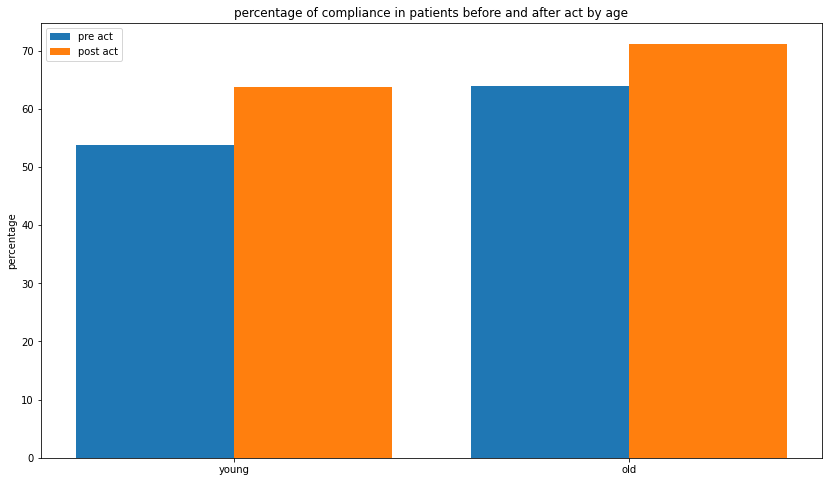

In [288]:
# graphs
# patient cohort from 2017 - 2018

# age
X = ['young', 'old']
pre_act = [53.7, 63.9]
post_act = [63.7, 71.2]

X_axis = np.arange(len(X))

plt.figure(figsize=(14, 8))

plt.bar(X_axis - 0.2, pre_act, 0.4, label='pre act')
plt.bar(X_axis + 0.2, post_act, 0.4, label='post act')
plt.xticks(X_axis, X)
plt.ylabel('percentage')
plt.legend()
plt.title('percentage of compliance in patients before and after act by age')
plt.show()

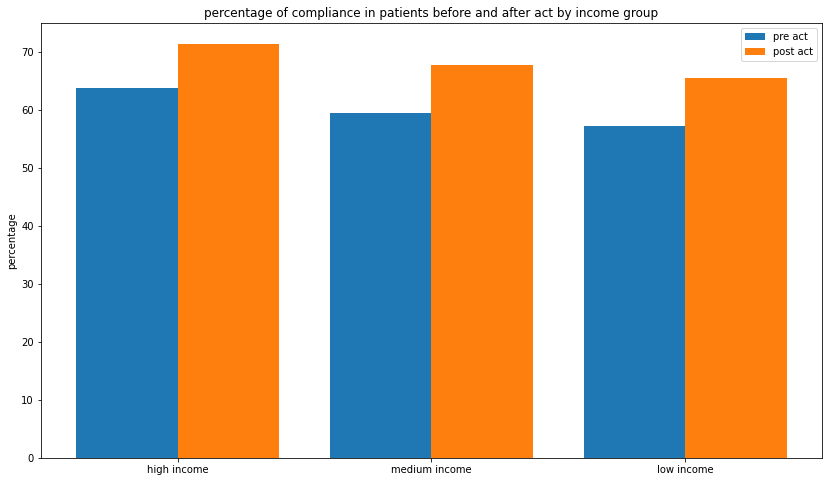

In [289]:
# graphs
# patient cohort from 2017 - 2018

# income group
X = ['high income', 'medium income', 'low income']
pre_act = [63.8, 59.4, 57.2]
post_act = [71.4, 67.8, 65.5]

X_axis = np.arange(len(X))

plt.figure(figsize=(14, 8))

plt.bar(X_axis - 0.2, pre_act, 0.4, label='pre act')
plt.bar(X_axis + 0.2, post_act, 0.4, label='post act')
plt.xticks(X_axis, X)
plt.ylabel('percentage')
plt.legend()
plt.title('percentage of compliance in patients before and after act by income group')
plt.show()

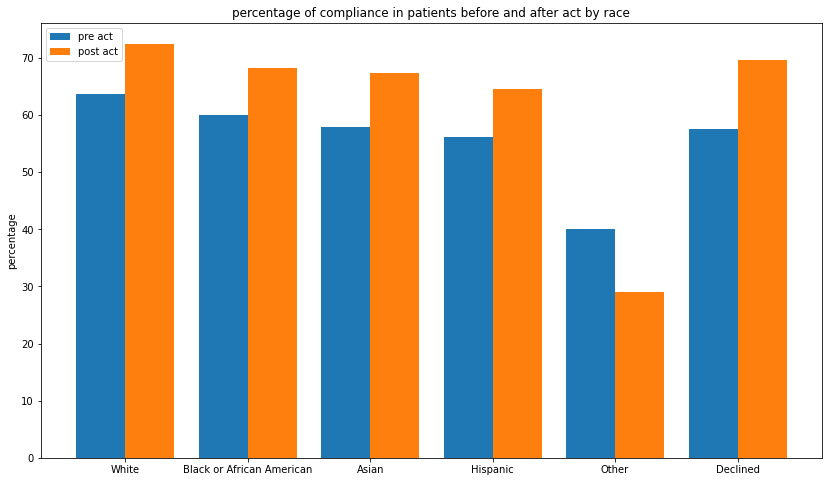

In [138]:
# graphs
# patient cohort from 2017 - 2018

# race
X = ['White', 'Black or African American', 'Asian', 'Hispanic', 'Other', 'Declined']
pre_act = [63.6, 60.0, 57.9, 56.1, 40.0, 57.6]
post_act = [72.5, 68.3, 67.3, 64.6, 29.1, 69.7]

X_axis = np.arange(len(X))

plt.figure(figsize=(14, 8))

plt.bar(X_axis - 0.2, pre_act, 0.4, label='pre act')
plt.bar(X_axis + 0.2, post_act, 0.4, label='post act')
plt.xticks(X_axis, X)
plt.ylabel('percentage')
plt.legend()
plt.title('percentage of compliance in patients before and after act by race')
plt.show()

In [196]:
# repeat compliance 
# pre act, compliance = patients with at least 3 visits
# and 1 visit is within a year from 7/22/2019

def apply_transformations(inp):
    df = inp[['customer_id', 'visit_datetime', 'zipcodeincome_percapita', 'race_type_code',
              'ethnic_origin_code', 'date_of_visit', 'date_of_birth']].copy()
    
    counts = df.groupby('customer_id')['customer_id'].agg('count').to_frame('num_visits')
    df = df.merge(counts, on='customer_id', how='inner')
    
    bins = [0, 50000, 85000, 10000000]
    labels = ['Low', 'Medium', 'High']
    df.loc[:, 'income_group'] = pd.cut(df.zipcodeincome_percapita, bins, labels=labels)

    df.loc[:, 'age'] = parallelize_on_rows(df, get_age, num_of_processes=12)
    df.loc[:, 'young'] = df['age'] < 50
    df.loc[:, 'race'] = parallelize_on_rows(df, get_race, num_of_processes=12)

    cohort = df[['customer_id', 'visit_datetime', 'race', 'income_group', 'young', 'num_visits']]
    print(cohort.shape)
    return cohort

In [202]:
act = pd.to_datetime('2019-07-22')
visits_pre_act = visits_scr_cst_act[visits_scr_cst_act['visit_datetime'] < act]

(580296, 50)

In [217]:
df = apply_transformations(visits_pre_act)
total_patients = df.drop_duplicates('customer_id')
print(total_patients.shape)
df.head()

(580296, 6)
(231670, 6)


,customer_id,visit_datetime,race,income_group,young,num_visits
0,6051340,2017-11-24,Black or African American,Medium,False,1
1,6026362,2017-09-05,Black or African American,Medium,False,1
2,5368143,2016-11-03,Asian,Medium,True,1
3,4828756,2014-11-18,Black or African American,High,False,2
4,4828756,2016-01-13,Black or African American,High,False,2


In [218]:
# have number of visits for every customer_id
df = df[df['num_visits'] >= 3]
df.shape

# all patients that satisfy compliance 
yr_before_act = pd.to_datetime('2018-07-22')
df = df[(df['visit_datetime'] > yr_before_act) & (df['visit_datetime'] < act)]
df = df.drop_duplicates('customer_id')
print(df.shape)
df.head()

(75182, 6)


,customer_id,visit_datetime,race,income_group,young,num_visits
40,5423707,2018-10-02,White,High,True,4
51,5313939,2018-12-05,Other,High,False,3
70,5500784,2018-10-23,Black or African American,High,False,4
73,4320302,2018-08-01,White,Medium,False,5
83,1273255,2018-12-21,Black or African American,High,False,4


In [219]:
print('pre act compliance')
get_percentage(df['race'], total_patients['race'])

pre act compliance
Compliance rate of White: 35.8% (47144 / 131524)
47144 complied, 131524 total

Compliance rate of Black or African American: 30.3% (19886 / 65545)
19886 complied, 65545 total

Compliance rate of Asian: 28.4% (3310 / 11642)
3310 complied, 11642 total

Compliance rate of Hispanic: 25.2% (2111 / 8392)
2111 complied, 8392 total

Compliance rate of Other: 16.2% (1868 / 11538)
1868 complied, 11538 total

Compliance rate of Declined: 28.5% (863 / 3029)
863 complied, 3029 total



In [221]:
get_percentage(df['income_group'], total_patients['income_group'])

Compliance rate of High: 35.5% (34635 / 97519)
34635 complied, 97519 total

Compliance rate of Medium: 30.7% (33302 / 108317)
33302 complied, 108317 total

Compliance rate of Low: 28.1% (7241 / 25807)
7241 complied, 25807 total



In [220]:
get_percentage(df['young'], total_patients['young'])

Compliance rate of False: 39.0% (61636 / 158138)
61636 complied, 158138 total

Compliance rate of True: 18.4% (13546 / 73532)
13546 complied, 73532 total



In [ ]:
def apply_transformations(inp):
    df = inp[['customer_id', 'visit_datetime', 'zipcodeincome_percapita', 'race_type_code',
              'ethnic_origin_code', 'date_of_visit', 'date_of_birth']].copy()
    
    counts = df.groupby('customer_id')['customer_id'].agg('count').to_frame('num_visits')
    df = df.merge(counts, on='customer_id', how='inner')
    
    bins = [0, 50000, 85000, 10000000]
    labels = ['Low', 'Medium', 'High']
    df.loc[:, 'income_group'] = pd.cut(df.zipcodeincome_percapita, bins, labels=labels)

    df.loc[:, 'age'] = parallelize_on_rows(df, get_age, num_of_processes=12)
    df.loc[:, 'young'] = df['age'] < 50
    df.loc[:, 'race'] = parallelize_on_rows(df, get_race, num_of_processes=12)

    cohort = df[['customer_id', 'visit_datetime', 'race', 'income_group', 'young', 'num_visits']]
    print(cohort.shape)
    return cohort

In [251]:
act = pd.to_datetime('2019-07-22')
visits_post_act = visits_scr_cst_act[visits_scr_cst_act['visit_datetime'] > act].copy()

visits_post_act['five_yrs_before'] = visits_post_act.loc[:, 'visit_datetime'] - pd.DateOffset(months=60)

cohort = visits_scr_cst_act[visits_scr_cst_act['customer_id'].isin(visits_post_act['customer_id'])]

cohort = cohort.merge(visits_post_act[['customer_id', 'five_yrs_before']], on='customer_id', how='inner')
cohort = cohort[cohort['visit_datetime'] > cohort['five_yrs_before']]

df = apply_transformations(cohort)
total_patients = df.drop_duplicates('customer_id')
print(total_patients.shape)
df.head()

(733969, 6)
(144019, 6)


,customer_id,visit_datetime,race,income_group,young,num_visits
0,4822259,2018-11-05,Black or African American,High,False,2
1,4822259,2019-11-27,Black or African American,High,False,2
2,4869751,2015-09-15,White,Medium,True,3
3,4869751,2019-08-14,White,Medium,False,3
4,4869751,2016-12-12,White,Medium,True,3


In [253]:
# have number of visits for every customer_id
# all patients that satisfy compliance
df = df[df['num_visits'] >= 3]
df = df.drop_duplicates('customer_id')
print(df.shape)
df.head()

(111245, 6)


,customer_id,visit_datetime,race,income_group,young,num_visits
2,4869751,2015-09-15,White,Medium,True,3
5,5637177,2015-01-27,Black or African American,Medium,False,4
9,5419194,2019-12-21,White,High,False,3
14,4650327,2017-08-05,Black or African American,Medium,False,4
18,5313939,2020-08-27,Other,High,False,3


In [254]:
print('post act compliance')
get_percentage(df['race'], total_patients['race'])
get_percentage(df['income_group'], total_patients['income_group'])
get_percentage(df['young'], total_patients['young'])


post act compliance
Compliance rate of White: 79.6% (68583 / 86202)
68583 complied, 86202 total

Compliance rate of Black or African American: 75.0% (30652 / 40843)
30652 complied, 40843 total

Compliance rate of Asian: 73.1% (5260 / 7199)
5260 complied, 7199 total

Compliance rate of Hispanic: 69.1% (3596 / 5205)
3596 complied, 5205 total

Compliance rate of Other: 68.6% (1681 / 2450)
1681 complied, 2450 total

Compliance rate of Declined: 69.5% (1473 / 2120)
1473 complied, 2120 total

Compliance rate of Medium: 76.3% (50298 / 65941)
50298 complied, 65941 total

Compliance rate of High: 79.2% (49863 / 62984)
49863 complied, 62984 total

Compliance rate of Low: 73.4% (11080 / 15086)
11080 complied, 15086 total

Compliance rate of False: 80.7% (86641 / 107321)
86641 complied, 107321 total

Compliance rate of True: 67.0% (24604 / 36698)
24604 complied, 36698 total

